# Парсинг обещание.ru

Сервис контроля обещаний и предсказаний различных публичных людей.<br>
В данном случае будут сравниваться обещания Путина и Медведева.
Используем расширения для Chrome для удобного парсинга http://selectorgadget.com (+ используем fromstring из либы lxml)

Будем мультипоточно качать сразу по 50 статей с сайта одновременно (Pool)

In [1]:
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import requests
from multiprocessing.dummy import Pool
from lxml.html import fromstring

def get_page(url):
    html = requests.get(url).text
    dom = fromstring(html)
    dom.make_links_absolute(url)
    return dom

def get_article_urls(url_date):
    pattern = '.title-link'
    dom = get_page(url_date)
    return [t.attrib['href'] for t in dom.cssselect(pattern)]

def get_article_text(url):
    pattern_header = 'h1'
    patterns = ['.normalize p']
    
    try:
        dom = get_page(url)
    except:
        return None, None
    
    try:
        header = dom.cssselect(pattern_header)[0].text_content().strip()
    except:
        header = ""

    try:
        css_elements = flatten([dom.cssselect(pattern) for pattern in patterns])
        text = "\n\n".join([t.text_content().strip() for t in css_elements])
    except:
        text = ""

    return header, text

flatten = lambda l: [item for sublist in l for item in sublist]

In [210]:
def url_pages(person):
    url_page_template_1 = f'http://www.obeschania.ru/documents/?order_type=desc&type=promises&topic=&person={person}&organization=&region=&status_active=on&from_date=&to_date=&execute_from_date=&execute_to_date='
    url_page_template_2 = f'http://www.obeschania.ru/documents/?order_type=desc&region=&execute_to_date=&topic=&person={person}&from_date=&to_date=&organization=&execute_from_date=&type=promises&page='
    url_pages = [url_page_template_1]
    for page in range(2, 18):
        url_page_template = url_page_template_2.replace('page=', f'page={page}')
        url_pages.append(url_page_template)
    return url_pages

In [211]:
url_pages_putin = url_pages(1)
url_pages_medvedev = url_pages(2)

In [212]:
pool = Pool(100)

In [213]:
%%time
url_articles_putin = pool.map(get_article_urls, url_pages_putin)
url_articles_putin = flatten(url_articles_putin)
url_articles_medvedev = pool.map(get_article_urls, url_pages_medvedev)
url_articles_medvedev = flatten(url_articles_medvedev)

CPU times: user 1.08 s, sys: 41.9 ms, total: 1.12 s
Wall time: 6.44 s


вот сколько ссылок на статьи теперь у нас есть

In [214]:
len(url_articles_putin), len(url_articles_medvedev)

(170, 166)

In [215]:
urls_putin = url_articles_putin
urls_medvedev = url_articles_medvedev

In [219]:
df_putin = pd.DataFrame({"url": urls_putin})
df_medvedev = pd.DataFrame({"url": urls_medvedev})

In [220]:
df_putin['person'] = 'Путин'
df_medvedev['person'] = 'Медведев'

In [222]:
df_putin.head()

,url,person
0,http://www.obeschania.ru/documents/promises/so...,Путин
1,http://www.obeschania.ru/documents/promises/pe...,Путин
2,http://www.obeschania.ru/documents/promises/ar...,Путин
3,http://www.obeschania.ru/documents/promises/ar...,Путин
4,http://www.obeschania.ru/documents/promises/pu...,Путин


In [223]:
df_medvedev.head()

,url,person
0,http://www.obeschania.ru/documents/promises/pl...,Медведев
1,http://www.obeschania.ru/documents/promises/me...,Медведев
2,http://www.obeschania.ru/documents/promises/st...,Медведев
3,http://www.obeschania.ru/documents/promises/me...,Медведев
4,http://www.obeschania.ru/documents/promises/re...,Медведев


скачаем тексты статей

In [224]:
from tqdm import tqdm

In [225]:
%%time
headers_texts_putin = pool.map(get_article_text, urls_putin)

CPU times: user 4.01 s, sys: 137 ms, total: 4.15 s
Wall time: 8.33 s


In [226]:
%%time
headers_texts_medvedev = pool.map(get_article_text, urls_medvedev)

CPU times: user 3.95 s, sys: 133 ms, total: 4.08 s
Wall time: 6.62 s


In [227]:
pool.close()
pool.join()

объединим в датасет

In [228]:
df_putin["header"] = [t[0] for t in headers_texts_putin]
df_putin["text"] = [t[1] for t in headers_texts_putin]
df_medvedev["header"] = [t[0] for t in headers_texts_medvedev]
df_medvedev["text"] = [t[1] for t in headers_texts_medvedev]

In [229]:
df_putin.head()

,url,person,header,text
0,http://www.obeschania.ru/documents/promises/so...,Путин,Соревнования для паралимпийцев будут проводить...,Открытые соревнования для паралимпийцев будут ...
1,http://www.obeschania.ru/documents/promises/pe...,Путин,Поможем со строительством перинатального центр...,Президент РФ Владимир Путин пообещал помочь со...
2,http://www.obeschania.ru/documents/promises/ar...,Путин,Перевооружение российской армии и флота заверш...,Масштабное перевооружение российской армии и ф...
3,http://www.obeschania.ru/documents/promises/ar...,Путин,"Лично проверю результаты ""генеральной уборки"" ...",Президенту РФ Владимир Путин пообещал в следую...
4,http://www.obeschania.ru/documents/promises/pu...,Путин,Сохраним поддержку материнства в числе национа...,Президент РФ Владимир Путин в ходе церемонии в...


In [230]:
df_medvedev.head()

,url,person,header,text
0,http://www.obeschania.ru/documents/promises/pl...,Медведев,Примем план развития конкуренции в России,В ближайшее время будет разработан и представл...
1,http://www.obeschania.ru/documents/promises/me...,Медведев,"""Единая Россия"" не будет принимать непопулярны...","""Единая Россия"" не будет ""отдыхать"" после побе..."
2,http://www.obeschania.ru/documents/promises/st...,Медведев,Льготная ставка по кредитам для аграриев зараб...,Льготная ставка по кредитам для аграриев в 5% ...
3,http://www.obeschania.ru/documents/promises/me...,Медведев,Россия будет отстаивать права своих граждан в ...,Россия как сильное и влиятельное государство б...
4,http://www.obeschania.ru/documents/promises/re...,Медведев,Правительство выполнит программу строительства...,Правительство РФ несмотря на сложности с бюдже...


In [231]:
df_putin.shape, df_medvedev.shape

((170, 4), (166, 4))

In [232]:
df_putin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 4 columns):
url       170 non-null object
person    170 non-null object
header    170 non-null object
text      170 non-null object
dtypes: object(4)
memory usage: 5.4+ KB


In [233]:
df_medvedev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 4 columns):
url       166 non-null object
person    166 non-null object
header    166 non-null object
text      166 non-null object
dtypes: object(4)
memory usage: 5.3+ KB


In [234]:
df = pd.concat([df_putin, df_medvedev])

In [236]:
df.to_pickle('promises.pkl')

длина заголовка

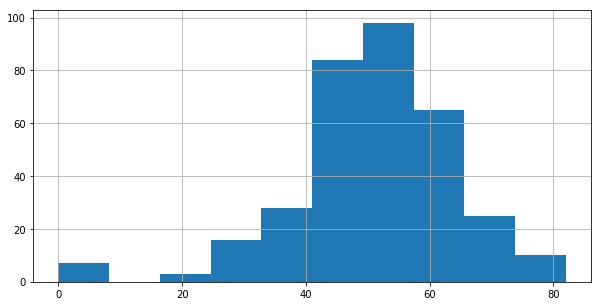

In [237]:
plt.figure(figsize=(10,5))
ax = df.header.apply(len).hist()

длина текста

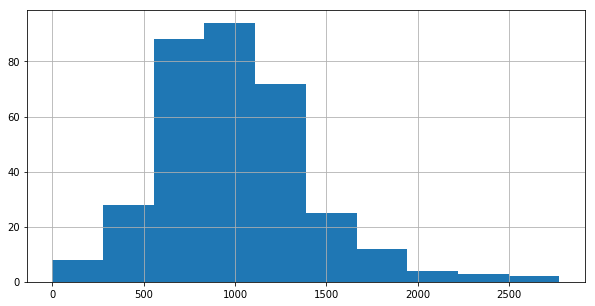

In [238]:
plt.figure(figsize=(10,5))
ax = df.text.apply(len).hist()

# Лемматизация слов

приведём все слова в текстах к начальной форме слова - так мы сильно сократим размерность пространства признаков

хоть pymorphy2 и достаточно быстрый, лучше его упаковывать в класс со своим кэшем (который хорошо бы ещё куда-то выгружать при окончании и загружать в начале работы, это можете доделать. Удобно для этих целей использовать json)

In [239]:
import pymorphy2
from nltk.tokenize import word_tokenize

In [302]:
stopw = set([u'это', u'году', u'года', u'также', u'этот',
        u'которые', u'который', u'которая', u'поэтому',
        u'весь', u'свой', u'мочь', u'eтот', u'например',
        u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
        u'источник', u'стать', u'время', u'пока', u'однако',
        u'около', u'немного', u'кроме', u'гораздо', u'каждый',
        u'первый', u'вполне', u'из-за', u'из-под',
        u'второй', u'нужно', u'нужный', u'просто', u'большой',
        u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
        u'метр', u'получить', u'далее', u'именно', u'апрель',
        u'сообщать', u'разный', u'говорить', u'делать', u'год', u'быть',
        u'появиться', u'2016', u'март', u'2019', u'человек', u'россия',
        u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
        u'ничто', u'достаточно', u'использовать', u'путин', u'медведев', 
        u'принять', u'практически', u'жизнь', u'что', u'президент',
        u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
        u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
        u'остаться', u'заявить', u'сделать', u'дело',
        u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
        u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
        u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
        u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать',
        u'правительство', u'дмитрий', u'российский', u'премьер-министр',
        u'тот', u'владимир', u'государство', u'страна', u'российский',
        u'глава', u'для', u'тот', u'2018', u'срок', u'наш', u'она', u'уже', u'только',
        u'они', u'такой', u'чтобы', u'при', u'как', u'премьер', u'председатель', 
        u'ещё', u'президентский',]
)



In [307]:
class MorphProvider:
    def __init__(self):
        self.cache = {}
        self.morph = pymorphy2.MorphAnalyzer()
    
    def __call__(self, w):
        w = w.lower()
        cached = self.cache.get(w)
        if cached:
            return cached
        try:
            morphed = self.morph.parse(w)[0].normal_form
            if morphed not in stopw:
                self.cache[w] = morphed
                return morphed 
            return ''
        except:
            return None
    
    def morph_string(self, s):
        words = word_tokenize(s)
        return " ".join([self.__call__(w) for w in words])

In [308]:
morph = MorphProvider()

In [309]:
from tqdm import tqdm

In [310]:
df["normalized"] = [morph.morph_string(t) for t in tqdm(df.text)]





  0%|          | 0/336 [00:00<?, ?it/s]



  1%|          | 2/336 [00:00<00:20, 16.13it/s]



  1%|          | 4/336 [00:00<00:19, 17.00it/s]



  2%|▏         | 6/336 [00:00<00:19, 16.78it/s]



  2%|▏         | 8/336 [00:00<00:19, 16.60it/s]



  3%|▎         | 10/336 [00:00<00:18, 17.21it/s]



  4%|▍         | 13/336 [00:00<00:16, 19.01it/s]



  5%|▍         | 16/336 [00:00<00:15, 20.42it/s]



  6%|▌         | 19/336 [00:00<00:16, 19.73it/s]



  6%|▋         | 21/336 [00:01<00:16, 19.31it/s]



  7%|▋         | 25/336 [00:01<00:13, 22.56it/s]



  8%|▊         | 28/336 [00:01<00:13, 23.38it/s]



  9%|▉         | 31/336 [00:01<00:13, 22.64it/s]



 11%|█         | 36/336 [00:01<00:11, 26.11it/s]



 12%|█▏        | 39/336 [00:01<00:12, 23.87it/s]



 12%|█▎        | 42/336 [00:01<00:13, 21.23it/s]



 13%|█▎        | 45/336 [00:02<00:14, 19.88it/s]



 14%|█▍        | 48/336 [00:02<00:15, 18.28it/s]



 15%|█▌        | 51/336 [00:02<00:15, 18.79it/s]



 16%|█▌        | 54/3

In [314]:
from sklearn.externals import joblib

In [315]:
df["normalized"].head()

0    открытый соревнование  паралимпиец  проводитьс...
1     рф   пообещать помочь с строительство перинат...
2    масштабный перевооружение  армия и флот законч...
3     рф   пообещать в следующий  прилететь в аркти...
4     рф   в ход церемония вручение орден `` родите...
Name: normalized, dtype: object

In [316]:
df.to_pickle('./data/promises.pkl')
df = joblib.load('./data/promises.pkl')

# Облако слов

*4 fun*

In [317]:
from collections import Counter

In [318]:
words_putin = [w for w in " ".join(df[df['person']=='Путин'].normalized).split() if len(w)>2]
words_medvedev = [w for w in " ".join(df[df['person']=='Медведев'].normalized).split() if len(w)>2]

In [319]:
Counter(words_putin).most_common()[:20]

[('май', 84),
 ('отметить', 81),
 ('полномочие', 72),
 ('истекать', 71),
 ('пообещать', 71),
 ('подчеркнуть', 57),
 ('напомнить', 54),
 ('один', 54),
 ('сообщить', 48),
 ('ход', 44),
 ('крым', 44),
 ('система', 44),
 ('миллиард', 43),
 ('федеральный', 42),
 ('рубль', 39),
 ('два', 36),
 ('встреча', 35),
 ('развитие', 33),
 ('власть', 33),
 ('после', 32)]

In [301]:
Counter(words_medvedev).most_common()[:20]

[('рубль', 70),
 ('отметить', 69),
 ('май', 67),
 ('развитие', 62),
 ('пообещать', 61),
 ('полномочие', 59),
 ('федеральный', 56),
 ('программа', 56),
 ('подчеркнуть', 51),
 ('истекать', 49),
 ('бюджет', 48),
 ('решение', 46),
 ('миллиард', 45),
 ('регион', 42),
 ('единый', 41),
 ('сообщить', 41),
 ('более', 39),
 ('тысяча', 38),
 ('ближний', 37),
 ('напомнить', 36)]

In [320]:
from wordcloud import WordCloud

def get_wordcloud(text,max_font_size=None):
    wordcloud = WordCloud(max_font_size=max_font_size).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")

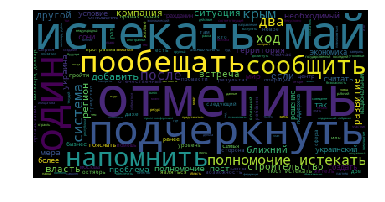

In [321]:
get_wordcloud(' '.join(words_putin))

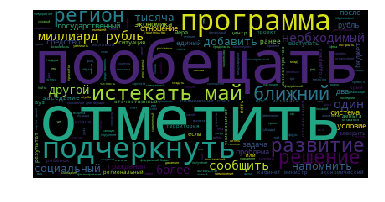

In [322]:
get_wordcloud(' '.join(words_medvedev))

-----

# Классификация обещаний политиков с сайта www.obeschania.ru

Попробуем по тексту обещания определить политика.

### Данные

In [324]:
df.head()

,url,person,header,text,normalized
0,http://www.obeschania.ru/documents/promises/so...,Путин,Соревнования для паралимпийцев будут проводить...,Открытые соревнования для паралимпийцев будут ...,открытый соревнование паралимпиец проводитьс...
1,http://www.obeschania.ru/documents/promises/pe...,Путин,Поможем со строительством перинатального центр...,Президент РФ Владимир Путин пообещал помочь со...,рф пообещать помочь с строительство перинат...
2,http://www.obeschania.ru/documents/promises/ar...,Путин,Перевооружение российской армии и флота заверш...,Масштабное перевооружение российской армии и ф...,масштабный перевооружение армия и флот законч...
3,http://www.obeschania.ru/documents/promises/ar...,Путин,"Лично проверю результаты ""генеральной уборки"" ...",Президенту РФ Владимир Путин пообещал в следую...,рф пообещать в следующий прилететь в аркти...
4,http://www.obeschania.ru/documents/promises/pu...,Путин,Сохраним поддержку материнства в числе национа...,Президент РФ Владимир Путин в ходе церемонии в...,рф в ход церемония вручение орден `` родите...


In [325]:
df.person.value_counts()

Путин       170
Медведев    166
Name: person, dtype: int64

In [326]:
df.index = range(len(df))

In [329]:
df.head()

,url,person,header,text,normalized
0,http://www.obeschania.ru/documents/promises/so...,Путин,Соревнования для паралимпийцев будут проводить...,Открытые соревнования для паралимпийцев будут ...,открытый соревнование паралимпиец проводитьс...
1,http://www.obeschania.ru/documents/promises/pe...,Путин,Поможем со строительством перинатального центр...,Президент РФ Владимир Путин пообещал помочь со...,рф пообещать помочь с строительство перинат...
2,http://www.obeschania.ru/documents/promises/ar...,Путин,Перевооружение российской армии и флота заверш...,Масштабное перевооружение российской армии и ф...,масштабный перевооружение армия и флот законч...
3,http://www.obeschania.ru/documents/promises/ar...,Путин,"Лично проверю результаты ""генеральной уборки"" ...",Президенту РФ Владимир Путин пообещал в следую...,рф пообещать в следующий прилететь в аркти...
4,http://www.obeschania.ru/documents/promises/pu...,Путин,Сохраним поддержку материнства в числе национа...,Президент РФ Владимир Путин в ходе церемонии в...,рф в ход церемония вручение орден `` родите...


In [330]:
df['person'] = df['person'].map({'Путин': 1, 'Медведев': 0})

Уберём все токены, которые не являются словами, при этом все числа заменив на "num"

In [332]:
df["normalized_words"] = df.normalized.apply(lambda x: ' '.join([w if w.isalpha() else 'num' for w in x.split() if w.isalpha() or w.isdigit()]))

### Векторизуем тексты

Здесь мы немного забежим вперёд и используем векторизацию текста в мешок слов ([bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model))

In [333]:
from sklearn.feature_extraction.text import CountVectorizer

In [334]:
vectorizer = CountVectorizer(max_features=5000)

In [335]:
%%time
X = vectorizer.fit_transform(df.normalized_words).toarray()

CPU times: user 83.1 ms, sys: 0 ns, total: 83.1 ms
Wall time: 81.5 ms


In [336]:
y = df.person

In [337]:
from sklearn.model_selection import train_test_split

In [524]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8, test_size=0.15, stratify=y)

In [525]:
y_train.value_counts()

1    144
0    141
Name: person, dtype: int64

In [526]:
y_test.value_counts()

1    26
0    25
Name: person, dtype: int64

### Обучим обычным деревом

**Задание:** с помощью кросс-валидации по 10 фолдам и критерием качества f1 score подберите оптимальную глубину дерева в интервале 2-15

*можете переиспользовать код из тетрадки 2, но не забудьте настроить параметры*

К сожалению данных - мало, поэтому придется использовать вместо f1 - accuracy, иначе при обучении может встречаться ситуации, когда для расчета f1 не хватает каких либо данных.

In [527]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [528]:
X.shape

(336, 5000)

In [568]:
np.random.seed(8)
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

5

In [592]:
np.random.seed(8)
param_grid = {
        'max_depth': np.arange(2, 18),
        'max_features': ['sqrt', 'log2', None],
        'min_samples_leaf': np.arange(2, 10),
#         'min_samples_split': np.arange(2, 10),
        }

grid_search = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), 
        param_grid=param_grid, scoring='accuracy', cv=skf, return_train_score=True)

In [593]:
grid_search.fit(X_train, y_train)

/home/sergey/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), 'max_features': ['sqrt', 'log2', None], 'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [594]:
grid_search.best_score_

0.6350877192982456

In [595]:
grid_search.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=17,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [596]:
grid_search.best_params_

{'max_depth': 17, 'max_features': None, 'min_samples_leaf': 3}

In [597]:
model = grid_search.best_estimator_

### Делаем предсказание

Итак, кросс-валидация помогла нам выбрать глубину дерева. Обучим его с этим знанием

**Задание:** обучите дерево и сделайте предсказание как классов, так и вероятностей принадлежности классам

In [598]:
y_train_predict = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]

y_test_predict = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

### Оценим качество

**Задание:** оцените с помощью как минимум 3 метрик качество построенного решения

In [519]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import  f1_score, brier_score_loss

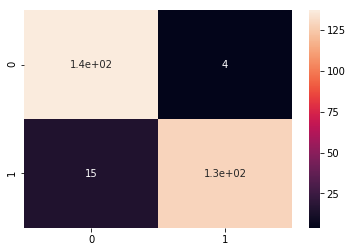

In [599]:
cm_train = confusion_matrix(y_train, y_train_predict)
ax = sns.heatmap(cm_train, annot=True)

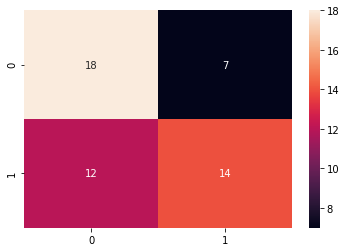

In [600]:
cm_test = confusion_matrix(y_test, y_test_predict)
ax = sns.heatmap(cm_test, annot=True)

In [601]:
accuracy_score(y_train, y_train_predict), accuracy_score(y_test, y_test_predict)

(0.9333333333333333, 0.6274509803921569)

In [602]:
f1_score(y_train, y_train_predict), f1_score(y_test, y_test_predict)

(0.9314079422382673, 0.5957446808510638)

In [603]:
brier_score_loss(y_train, y_train_prob), brier_score_loss(y_test, y_test_prob)

(0.04576023391812866, 0.3453754765795207)

Точность на тестовых данных получилась не высокой. Также, можно предположить, что обещания Путина и Медведева в целом могут быть очень похожими.

### Посмотрим на дерево решений

http://www.webgraphviz.com

In [604]:
from sklearn.tree import export_graphviz
import graphviz

In [608]:
dot_tree = export_graphviz(model, out_file=None, filled=True, 
                           feature_names=None, class_names=['Путин', 'Медведев'])

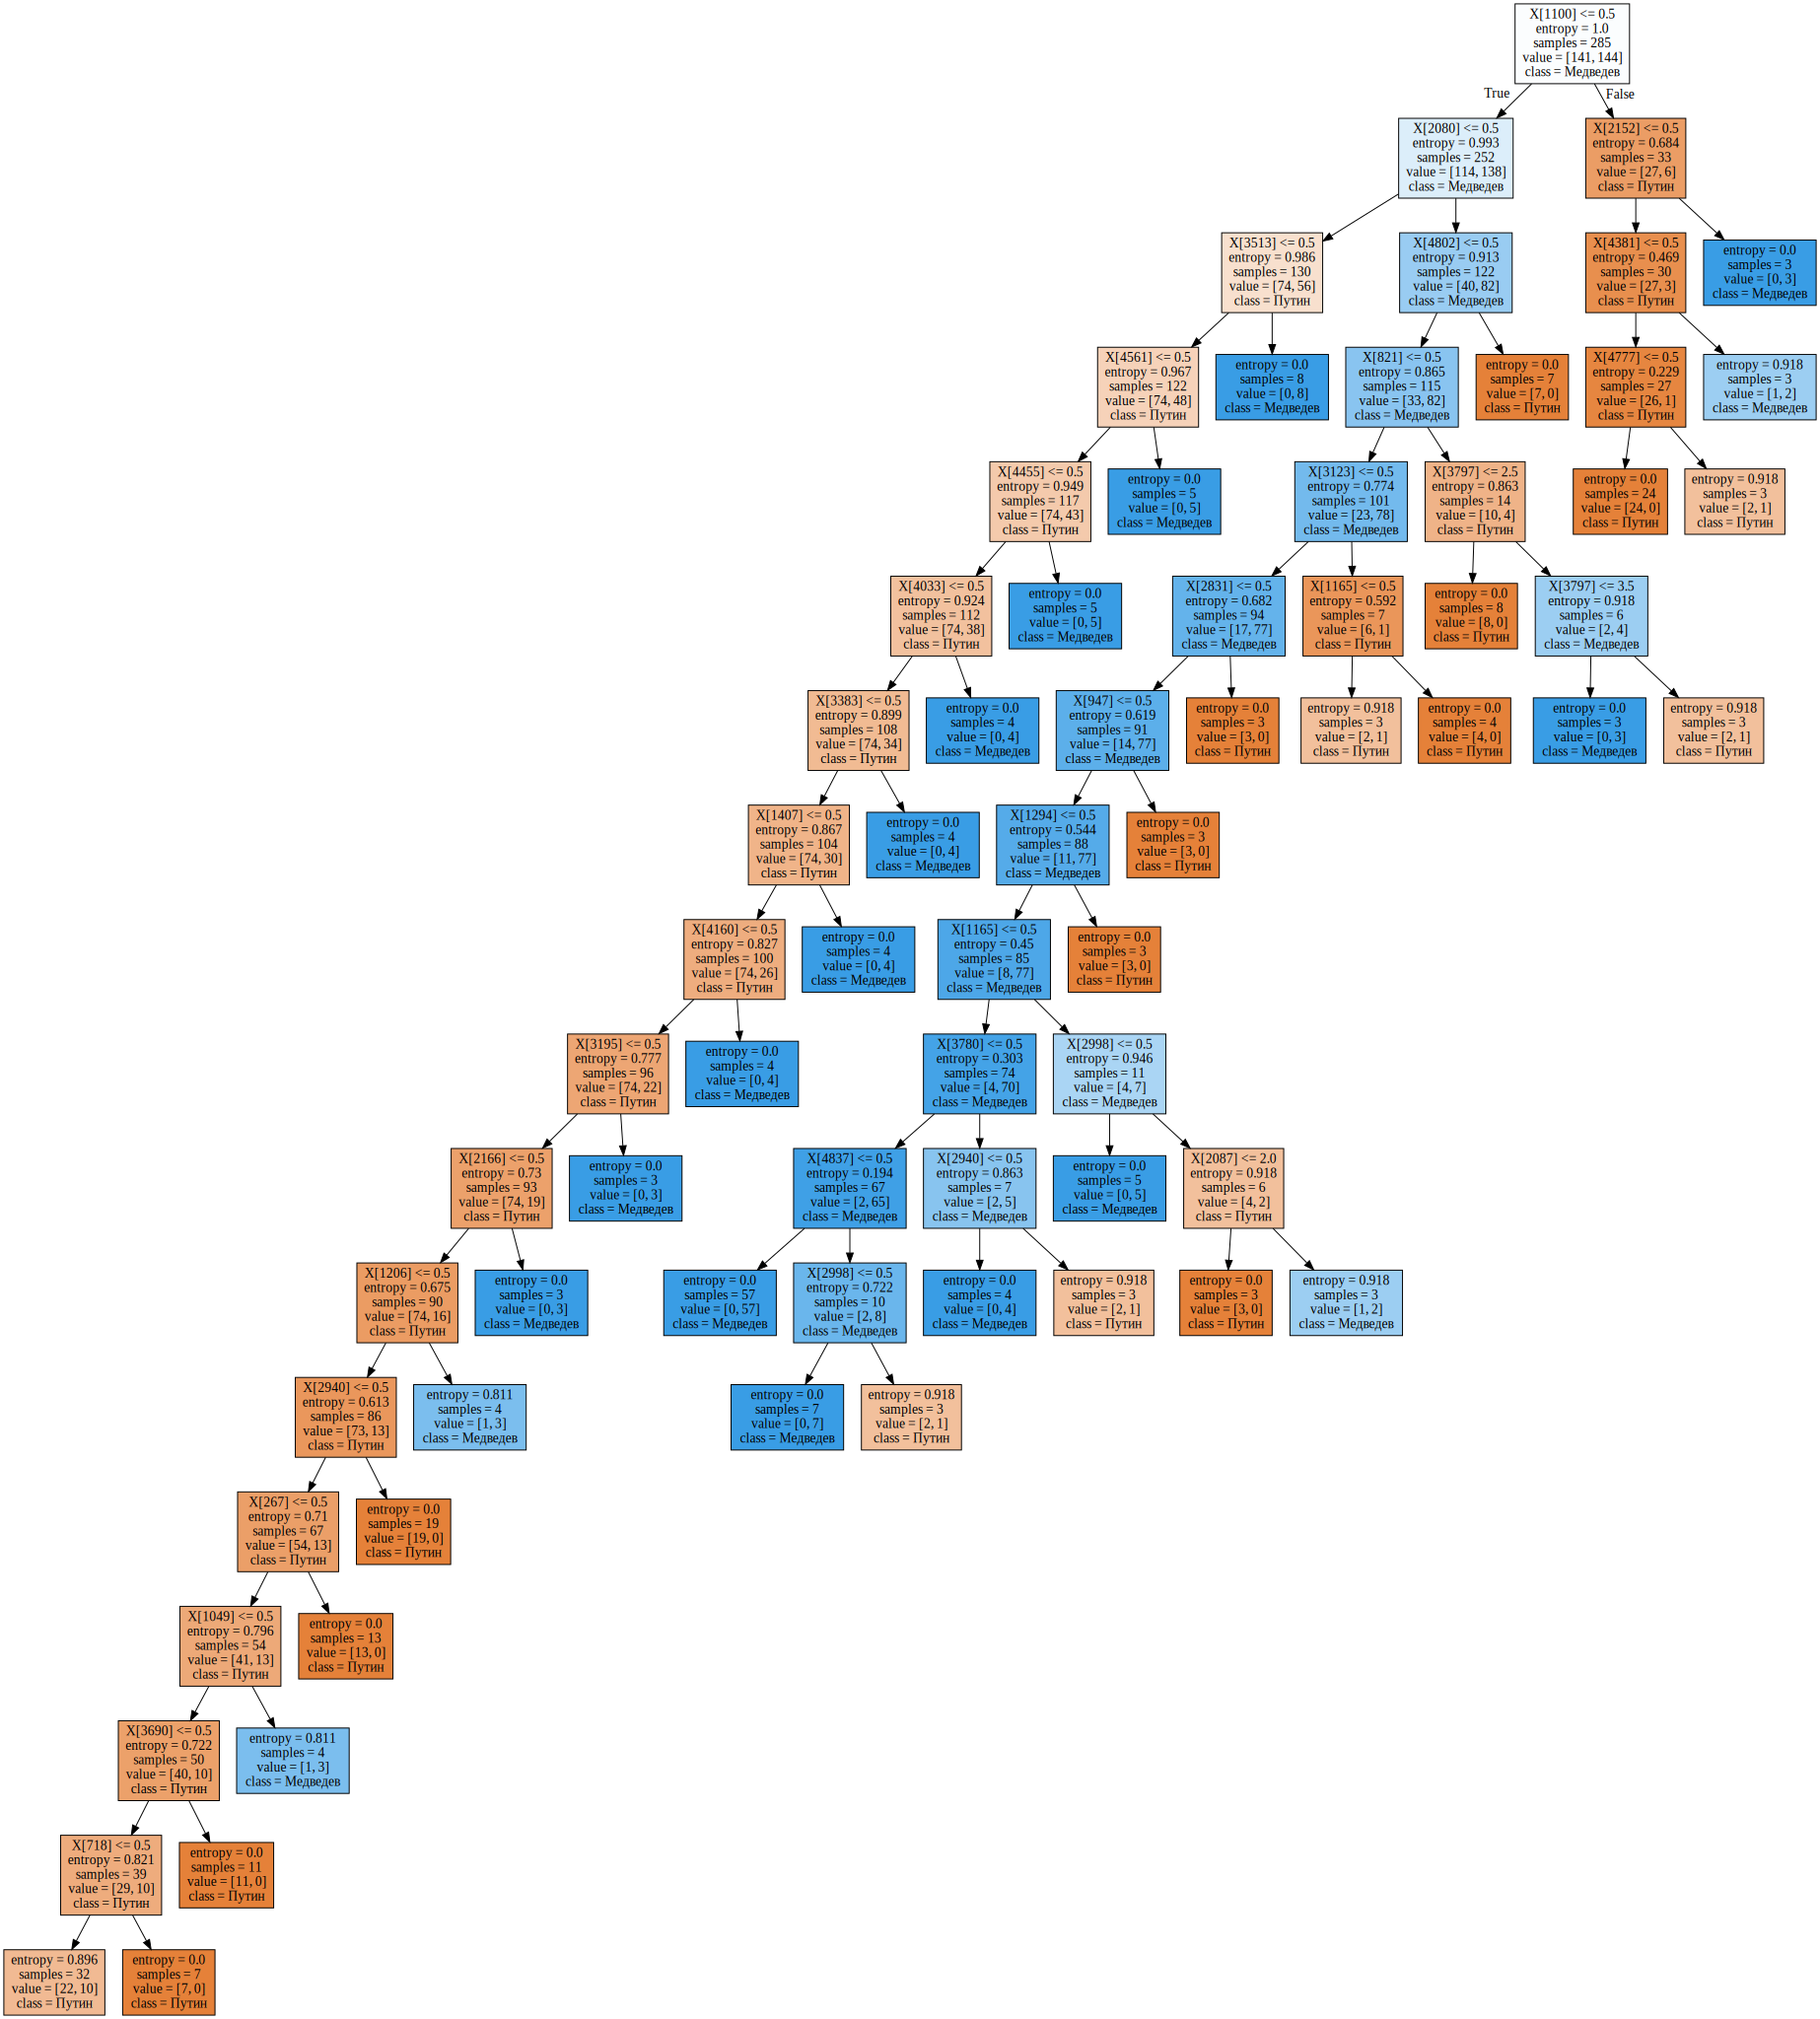

In [609]:
graph = graphviz.Source(dot_tree)
graph

### Какие слова самые важные?

In [610]:
def get_top_indexes(s):
    return sorted(range(len(s)), key=lambda k: s[k], reverse=True)

In [611]:
feature_names = vectorizer.get_feature_names()

In [612]:
top_indexes = get_top_indexes(model.feature_importances_)
top_indexes = top_indexes[:10]
top_indexes.reverse()

In [613]:
top_importances = [model.feature_importances_[i] for i in top_indexes]
top_words = [feature_names[i] for i in top_indexes]

''

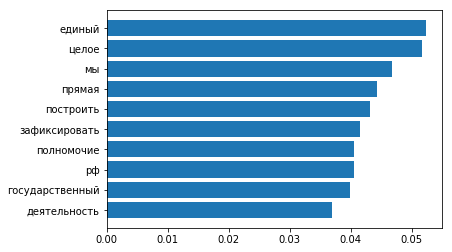

In [614]:
plt.barh(np.arange(len(top_importances)), top_importances)
plt.yticks(np.arange(len(top_words)), top_words)
''